In [9]:
from pynq import Overlay, GPIO, Register
from pynq import Xlnk
import numpy as np
import os
import inspect
class streamOverlay(Overlay):
    """A simple Stream Overlay for PYNQ.

    This overlay is implemented with a single Streaming HLS Core fed by
    a DMA Engine

    """
    __RESET_VALUE = 0
    __NRESET_VALUE = 1

    """For convenince, we define register offsets that are scraped from
    the filt1d implementation header files.

    """
    __FILT1D_AP_CTRL_OFF = 0x00
    __FILT1D_AP_CTRL_START_IDX = 0
    __FILT1D_AP_CTRL_DONE_IDX  = 1
    __FILT1D_AP_CTRL_IDLE_IDX  = 2
    __FILT1D_AP_CTRL_READY_IDX = 3

    __FILT1D_GIE_OFF     = 0x04
    __FILT1D_IER_OFF     = 0x08
    __FILT1D_ISR_OFF     = 0x0C
    __FILT1D_COEFF_OFFS  = [0x10, 0x18, 0x20, 0x28,
                            0x30, 0x38, 0x40, 0x48,
                            0x50]
    __FILT1D_OPTION_OFF  = 0x58
    def __init__(self, bitfile, **kwargs):
        """Initializes a new streamOverlay object.

        """
        # Get file path of the current class (i.e. /opt/python3.6/<...>/stream.py)
        file_path = os.path.abspath(inspect.getfile(inspect.currentframe()))
        # Get directory path of the current class (i.e. /opt/python3.6/<...>/stream/)
        dir_path = os.path.dirname(file_path)
        # Update the bitfile path to search in dir_path
        bitfile = os.path.join(dir_path, bitfile)
        # Upload the bitfile (and parse the colocated .tcl script)
        super().__init__(bitfile, **kwargs)
        # Manually define the GPIO pin that drives reset
        self.__resetPin = GPIO(GPIO.get_gpio_pin(0), "out")
        # Define a Register object at address 0x0 of the filt1d address space
        # We will use this to set bits and start the core (see start())
        # Do NOT write to __ap_ctrl unless __resetPin has been set to __NRESET_VALUE
        self.__ap_ctrl = Register(self.filter.mmio.base_addr, 32)
        self.xlnk = Xlnk()
        
    def __start(self):
        """Raise AP_START and enable the HLS core

        """
        self.__ap_ctrl[self.__FILT1D_AP_CTRL_START_IDX] = 1
        pass

    def __stop(self):
        """Lower AP_START and disable the HLS core

        """
        self.__ap_ctrl[self.__FILT1D_AP_CTRL_START_IDX] = 0
        pass

    def nreset(self):
        """Set the reset pin to self.__NRESET_VALUE to place the core into
        not-reset (usually run)

        """
        self.__resetPin.write(self.__NRESET_VALUE)
        
    def reset(self):
        """Set the reset pin to self.__RESET_VALUE to place the core into
        reset

        """
        self.__resetPin.write(self.__RESET_VALUE)

    def run(self, coeffs, buf, operation):
        """ Launch computation on the HLS core

        Parameters
        ----------
        coeffs: list
            A 9-element python list to transfer to the HLS Core for use
        as filter coefficients.
    
        buf : list
            An xlnk allocated buffer to be transferred to the core
        """
        # -------------------- Part 1: --------------------
        # Drop reset, and readying the core for use
        self.nreset()
        # Load the coefficients and length into the core registers
        l = len(buf)
        self.__load(coeffs, operation)

        # Create a source contiguous array for the DMA Engine and fill it with data
        cmabuf_src = self.xlnk.cma_array([l], np.int32)
        for i in range(l):
            cmabuf_src[i] = buf[i]

        # Create a destination contiguous array for the DMA Engine
        cmabuf_dest = self.xlnk.cma_array([l], np.int32)

        # -------------------- Part 2: --------------------
        # Initiate a transaction on the recieve channel (FPGA -> ARM) of the DMA engine
        self.axi_dma.recvchannel.transfer(cmabuf_dest)

        # Initiate a transaction on the transmit channel (ARM -> FPGA) of the DMA engine
        self.axi_dma.sendchannel.transfer(cmabuf_src)

        # Raise the AP_START bit of AP_CTRL to initiate computation
        self.__start()

        # Wait for the DMA engines to finish
        self.axi_dma.sendchannel.wait()
        self.axi_dma.recvchannel.wait()

        # Lower the AP_START bit of AP_CTRL to terminate computation
        self.__stop()

        # -------------------- Part 3: --------------------
        # Get the filtered signal as a python list from the destination DMA buffer
        buf = cmabuf_dest.tolist()
        
        # Free both buffers for reuse
        cmabuf_dest.freebuffer()
        cmabuf_src.freebuffer()

        # Return the filtered signal
        return buf

    def __load(self, coeffs, operation):
        """ Load the filter coefficients and signal length into the HLS core 

        Parameters
        ----------
        coeffs : list
            A list of coefficients to load into the core filter registers.
    
        leng : int
            The length of the signal to perform a filtering operation on

        """
        for (offset, coeff) in zip(self.__FILT1D_COEFF_OFFS, coeffs):
            self.filter.write(offset, coeff)

        self.filter.write(self.__FILT1D_OPTION_OFF, operation)

In [10]:
overlay = streamOverlay('base.bit')
overlay?

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x768 at 0xB00B6550>
<PIL.Image.Image image mode=L size=1024x768 at 0xAC167550>


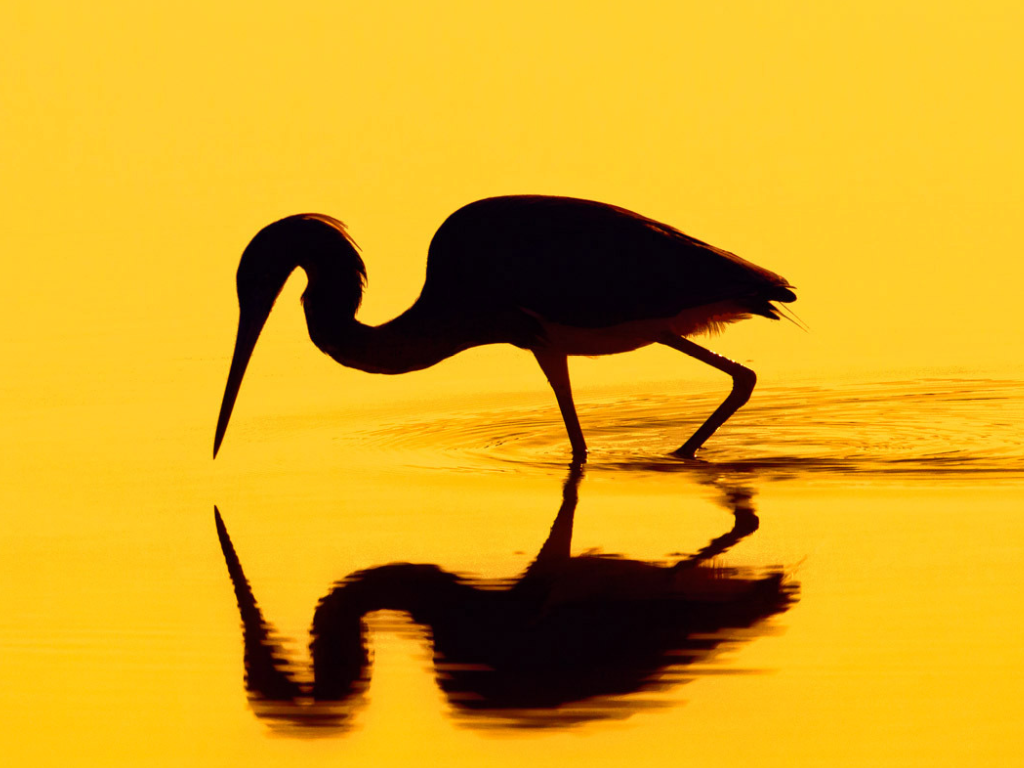

In [11]:
from PIL import Image
rgb = Image.open("animal.png")
print(rgb)
bw = rgb.convert("L")
print(bw)
rgb

# edge kernel
coeffs = [-1, -1, -1,
          -1,  8, -1,
          -1, -1, -1]

# sobel kernel
# coeffs_y = [-1, -2, -1,
#              0,  0,  0,
#              1,  2,  1]
# coeffs_x = [-1,  0,  1,
#             -2,  0,  2,
#             -1,  0,  1]
sig = list(bw.getdata())

# soble
# tmp = overlay.run(coeffs_x, sig, 0)
# output = overlay.run(coeffs_y, tmp, 0)

#edge detect
output = overlay.run(coeffs, sig, 0)
out = Image.new('RGB', bw.size)
out.putdata(output)
out